In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from joblib import dump
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from service.DataService import DataService
from service.ThingsBoardClientLight import ThingsBoardClientLight
from settings.Authentication import Authentication

In [2]:
# initialize ThingsboardClientLight
auth = Authentication()
ds = DataService()
tc = ThingsBoardClientLight(username=auth.USERNAME, api_url=auth.URL,
                          password=auth.PASSWORD)

In [3]:
# telemetrydata to PandasDataframe
df_325723 = ds.pickle_to_pandas_dataframe('6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce_Thesis_extended_newm_RAW',
                                         ['data_BatV', 'data_rssi', 'data_snr'],
                                         missing_values='lag_impute')
df_325733 = ds.pickle_to_pandas_dataframe('3f394130-a5f9-11ed-8fa7-8d95df41b8ce_Thesis_extended_newm_RAW',
                                         ['data_BatV', 'data_rssi', 'data_snr'],
                                         missing_values='lag_impute')


<Axes: xlabel='ts'>

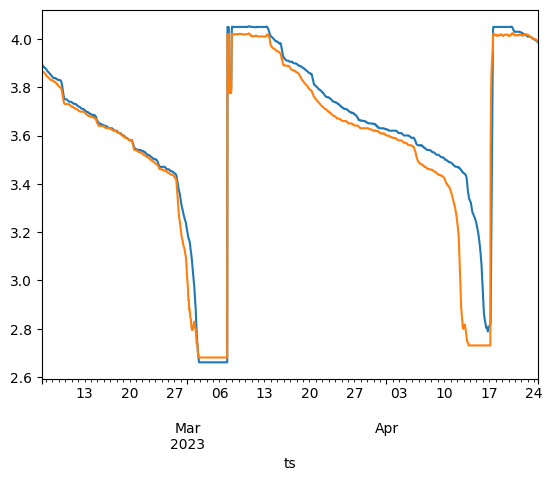

In [4]:
df_325723['rm_data_BatV'].plot()
df_325733['rm_data_BatV'].plot()

In [5]:
 # create full_curves for given datasets
df_325723_full_curve = ds.create_full_curve_thesis(df_325723, 'data_BatV')

df_325723_full_curve_1 = df_325723.loc[df_325723['data_BatV'].idxmax():].copy()
df_325723_full_curve_1 = df_325723_full_curve_1[20:]
df_325723_full_curve_1 = ds.create_full_curve_thesis(df_325723_full_curve_1, 'data_BatV')

df_325733_full_curve = ds.create_full_curve_thesis(df_325733, 'data_BatV')
df_325733_full_curve_1 = df_325733.loc[df_325733['data_BatV'].idxmax():].copy()
df_325733_full_curve_1 = df_325733_full_curve_1[20:]
df_325733_full_curve_1 = ds.create_full_curve_thesis(df_325733_full_curve_1, 'data_BatV')

In [6]:
df_train = pd.concat([df_325723_full_curve, df_325723_full_curve_1, df_325733_full_curve, df_325733_full_curve_1], ignore_index=True)
my_date_range = pd.date_range(end=df_325723.index[-1], periods=len(df_train), freq='H')
df_train['date'] = my_date_range
df_train.set_index('date', inplace=True)
df_train.fillna(0, inplace=True)

df_train.index.freq = 'H'

In [7]:
## TO TRAIN A NEW MODEL

X_train_raw = df_train[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_train_raw = df_train[['rm_data_BatV']].values

### Standardisierung von X
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_x.fit(X_train_raw)
X_train_std = scaler_x.transform(X_train_raw)
dump(scaler_x, '../../data/scaler/hyerparameter_scaler_x.joblib')

### Standardisierung von y
scaler_y = StandardScaler()
scaler_y.fit(y_train_raw)
y_train_std = scaler_y.transform(y_train_raw)
dump(scaler_y, '../../data/scaler/hyperparameter_scaler_y.joblib')

### Anwendung der Funktion auf vorbereitete Daten
window = 24
horizon = 1
indicators = 5

# restructure data for LSTM of customTB client
X_train, y_train = ds.restructure_data_for_lstm(X_train_std, y_train_std, window=window, horizon=horizon)

X_train.shape, y_train.shape

((3975, 24, 5), (3975, 1))

In [8]:
df_325723_test = df_325723[-140:]
df_325723_test = ds.create_full_curve_thesis(df_325723_test, 'data_BatV', test=True)

In [9]:
df_325733_test = df_325733[-145:]
df_325733_test = ds.create_full_curve_thesis(df_325733_test, 'data_BatV', test=True)

In [10]:
df_325723_test[df_325733_full_curve['sensor_id'][0]] = 0
df_325733_test[df_325723_full_curve['sensor_id'][0]] = 0

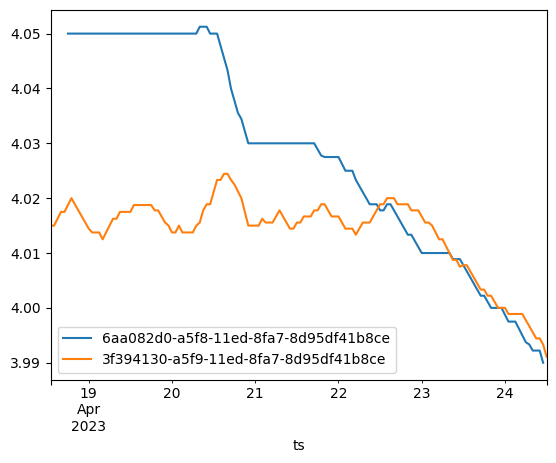

In [11]:
df_325723_test['rm_data_BatV'].plot(label=df_325723.iloc[1]['sensor_id'])
df_325733_test['rm_data_BatV'].plot(label=df_325733.iloc[1]['sensor_id'])
plt.legend()

In [12]:
X_test_23_raw = df_325723_test[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_test_23_raw = df_325723_test[['rm_data_BatV']].values

X_test_23_std = scaler_x.transform(X_test_23_raw)
y_test_23_std = scaler_y.transform(y_test_23_raw)

X_23_test, y_23_test = ds.restructure_data_for_lstm(X_test_23_std, y_test_23_std, window=window, horizon=horizon)

In [13]:
X_test_33_raw = df_325733_test[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_test_33_raw = df_325733_test[['rm_data_BatV']].values

X_test_33_std = scaler_x.transform(X_test_33_raw)
y_test_33_std = scaler_y.transform(y_test_33_raw)

X_33_test, y_33_test = ds.restructure_data_for_lstm(X_test_33_std, y_test_33_std, window=window, horizon=horizon)

In [14]:
def build_model(n_hidden=2, n_neurons=8, learning_rate=3e-3, input_shape=(window, indicators)):
    model = Sequential()
    model.add(LSTM(input_shape=input_shape, return_sequences=True, units=n_neurons, dropout=0.2))
    for i in range(n_hidden):
            model.add(LSTM(units=n_neurons, dropout=0.2))
    model.add(Dense(units=1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [15]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/var/folders/yq/sk49h1496dd6jjpb80f2pyph0000gn/T/ipykernel_24118/4087176523.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [16]:
early = EarlyStopping(monitor='val_loss', patience=9)
batch_size = 32

param_distribs = {
    'n_hidden': [0,1,2,3],
    'n_neurons': np.arange(6, 64),
    'learning_rate': reciprocal(3e-4, 3e-2),
}

tscv = TimeSeriesSplit(n_splits=2)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=15, cv=tscv)
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_23_test, y_23_test), shuffle=False, batch_size=batch_size, callbacks=[early])

2023-06-09 08:04:33.105053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-09 08:04:33.105368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Epoch 1/100


/Users/maximilianrupprecht/miniforge3/envs/thesis_maximilian_rupprecht/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-06-09 08:04:34.041399: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-09 08:04:34.833686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:34.993422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:35.112353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:35.238561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/42 [..............................] - ETA: 1:02 - loss: 1.3745

2023-06-09 08:04:35.434532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.3436

2023-06-09 08:04:36.841014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:36.890547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:36.960494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 3s 39ms/step - loss: 0.3436 - val_loss: 0.4260
Epoch 2/100
42/42 [==============================] - 1s 22ms/step - loss: 1.3948 - val_loss: 0.0815
Epoch 3/100
42/42 [==============================] - 1s 21ms/step - loss: 2.4383 - val_loss: 2.4158
Epoch 4/100
42/42 [==============================] - 1s 22ms/step - loss: 2.4350 - val_loss: 3.0002
Epoch 5/100
42/42 [==============================] - 1s 21ms/step - loss: 1.8361 - val_loss: 2.5645
Epoch 6/100
42/42 [==============================] - 1s 21ms/step - loss: 1.8069 - val_loss: 2.5780
Epoch 7/100
42/42 [==============================] - 1s 22ms/step - loss: 1.7934 - val_loss: 2.5615
Epoch 8/100
42/42 [==============================] - 1s 21ms/step - loss: 1.7836 - val_loss: 2.5428
Epoch 9/100
42/42 [==============================] - 1s 21ms/step - loss: 1.7181 - val_loss: 2.4421
Epoch 10/100
42/42 [==============================] - 1s 21ms/step - loss: 1.6589 - val_loss: 2.3256
Epoch 11/10

2023-06-09 08:04:47.525988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:47.666531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:47.746838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:47.848038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/83 [..............................] - ETA: 1:40 - loss: 0.8797

2023-06-09 08:04:47.976086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.3576

2023-06-09 08:04:50.177551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:50.228174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:04:50.297529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 4s 29ms/step - loss: 0.3576 - val_loss: 8.6681
Epoch 2/100
83/83 [==============================] - 2s 21ms/step - loss: 0.8761 - val_loss: 2.8272
Epoch 3/100
83/83 [==============================] - 2s 21ms/step - loss: 1.0978 - val_loss: 1.1738
Epoch 4/100
83/83 [==============================] - 2s 21ms/step - loss: 0.8158 - val_loss: 0.9931
Epoch 5/100
83/83 [==============================] - 2s 21ms/step - loss: 0.7011 - val_loss: 1.0756
Epoch 6/100
83/83 [==============================] - 2s 21ms/step - loss: 0.9117 - val_loss: 1.6629
Epoch 7/100
83/83 [==============================] - 2s 21ms/step - loss: 0.3403 - val_loss: 1.0281
Epoch 8/100
83/83 [==============================] - 2s 21ms/step - loss: 0.2929 - val_loss: 0.9092
Epoch 9/100
83/83 [==============================] - 2s 21ms/step - loss: 0.2539 - val_loss: 0.7897
Epoch 10/100
83/83 [==============================] - 2s 21ms/step - loss: 0.1476 - val_loss: 0.5836
Epoch 11/10

2023-06-09 08:05:38.605402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:05:38.704930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/42 [..............................] - ETA: 31s - loss: 1.6669

2023-06-09 08:05:38.844783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.5983

2023-06-09 08:05:39.867195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:05:39.900246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 2s 26ms/step - loss: 0.5983 - val_loss: 0.3595
Epoch 2/100
42/42 [==============================] - 1s 15ms/step - loss: 0.6398 - val_loss: 0.0675
Epoch 3/100
42/42 [==============================] - 1s 15ms/step - loss: 0.4076 - val_loss: 0.0633
Epoch 4/100
42/42 [==============================] - 1s 16ms/step - loss: 0.4488 - val_loss: 0.2592
Epoch 5/100
42/42 [==============================] - 1s 16ms/step - loss: 0.2950 - val_loss: 0.1490
Epoch 6/100
42/42 [==============================] - 1s 15ms/step - loss: 0.1785 - val_loss: 0.0142
Epoch 7/100
42/42 [==============================] - 1s 15ms/step - loss: 0.2077 - val_loss: 0.0272
Epoch 8/100
42/42 [==============================] - 1s 15ms/step - loss: 0.2198 - val_loss: 0.0500
Epoch 9/100
42/42 [==============================] - 1s 15ms/step - loss: 0.2295 - val_loss: 0.0445
Epoch 10/100
42/42 [==============================] - 1s 15ms/step - loss: 0.1804 - val_loss: 0.0075
Epoch 11/10

2023-06-09 08:05:58.478232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:05:58.577646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/83 [>.............................] - ETA: 1s - loss: 0.2676  

2023-06-09 08:05:58.692109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 3s 20ms/step - loss: 0.3546 - val_loss: 0.7427
Epoch 2/100


2023-06-09 08:06:00.271215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:06:00.307196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 1s 15ms/step - loss: 0.2900 - val_loss: 1.5887
Epoch 3/100
83/83 [==============================] - 1s 15ms/step - loss: 0.2827 - val_loss: 1.0295
Epoch 4/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1879 - val_loss: 0.4329
Epoch 5/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1768 - val_loss: 0.5111
Epoch 6/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1669 - val_loss: 0.3762
Epoch 7/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1384 - val_loss: 0.2704
Epoch 8/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1132 - val_loss: 0.3631
Epoch 9/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1256 - val_loss: 0.4412
Epoch 10/100
83/83 [==============================] - 1s 14ms/step - loss: 0.1415 - val_loss: 0.3851
Epoch 11/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1264 - val_loss: 0.0909
Epoch 12/1

2023-06-09 08:06:54.552352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:06:54.703140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:06:54.804057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:06:54.921098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/42 [..............................] - ETA: 55s - loss: 1.0192

2023-06-09 08:06:55.068075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.6834

2023-06-09 08:06:56.594909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:06:56.646122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:06:56.728414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 3s 43ms/step - loss: 0.6834 - val_loss: 0.0073
Epoch 2/100
42/42 [==============================] - 1s 22ms/step - loss: 0.1242 - val_loss: 0.0103
Epoch 3/100
42/42 [==============================] - 1s 22ms/step - loss: 0.1810 - val_loss: 0.0011
Epoch 4/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0840 - val_loss: 0.0111
Epoch 5/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0682 - val_loss: 6.5170e-04
Epoch 6/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0476 - val_loss: 0.0011
Epoch 7/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0608 - val_loss: 0.0056
Epoch 8/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0477 - val_loss: 7.7668e-04
Epoch 9/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0549 - val_loss: 0.0079
Epoch 10/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0425 - val_loss: 3.8281e-04

2023-06-09 08:07:20.584601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:20.742954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:20.835673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:20.947139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/83 [..............................] - ETA: 2:10 - loss: 0.9079

2023-06-09 08:07:21.094540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.4504

2023-06-09 08:07:23.559609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:23.608600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:23.690459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 4s 33ms/step - loss: 0.4504 - val_loss: 0.6008
Epoch 2/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0880 - val_loss: 0.1275
Epoch 3/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0486 - val_loss: 0.2776
Epoch 4/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0476 - val_loss: 0.3628
Epoch 5/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0522 - val_loss: 0.1347
Epoch 6/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0472 - val_loss: 0.1006
Epoch 7/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0493 - val_loss: 0.0014
Epoch 8/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0558 - val_loss: 0.0887
Epoch 9/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0481 - val_loss: 0.0260
Epoch 10/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0564 - val_loss: 0.0563
Epoch 11/10

2023-06-09 08:07:53.232362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:53.401966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:53.511908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:53.655787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/42 [..............................] - ETA: 58s - loss: 0.7441

2023-06-09 08:07:53.823216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.3906

2023-06-09 08:07:55.492969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:55.545546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:07:55.630397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 3s 46ms/step - loss: 0.3906 - val_loss: 9.9151e-04
Epoch 2/100
42/42 [==============================] - 1s 24ms/step - loss: 0.3287 - val_loss: 0.0039
Epoch 3/100
42/42 [==============================] - 1s 23ms/step - loss: 0.1399 - val_loss: 0.0153
Epoch 4/100
42/42 [==============================] - 1s 22ms/step - loss: 0.1812 - val_loss: 0.0818
Epoch 5/100
42/42 [==============================] - 1s 23ms/step - loss: 0.1286 - val_loss: 0.0519
Epoch 6/100
42/42 [==============================] - 1s 23ms/step - loss: 0.0720 - val_loss: 0.0045
Epoch 7/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0586 - val_loss: 5.7633e-04
Epoch 8/100
42/42 [==============================] - 1s 23ms/step - loss: 0.0546 - val_loss: 0.0014
Epoch 9/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0453 - val_loss: 5.2769e-04
Epoch 10/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0580 - val_loss: 0.0046

2023-06-09 08:08:13.113581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:08:13.266770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:08:13.372662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:08:13.503814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/83 [..............................] - ETA: 1:55 - loss: 1.2984

2023-06-09 08:08:13.674167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.4079

2023-06-09 08:08:16.189583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:08:16.238184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:08:16.320736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 4s 33ms/step - loss: 0.4079 - val_loss: 1.2258
Epoch 2/100
83/83 [==============================] - 2s 22ms/step - loss: 0.2618 - val_loss: 1.4714
Epoch 3/100
83/83 [==============================] - 2s 22ms/step - loss: 0.1493 - val_loss: 0.6609
Epoch 4/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0832 - val_loss: 0.3349
Epoch 5/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0592 - val_loss: 0.3065
Epoch 6/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0641 - val_loss: 0.4059
Epoch 7/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0426 - val_loss: 0.3271
Epoch 8/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0398 - val_loss: 0.3324
Epoch 9/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0393 - val_loss: 0.1870
Epoch 10/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0428 - val_loss: 0.2146
Epoch 11/10

2023-06-09 08:09:19.795356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:09:19.898395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/42 [..............................] - ETA: 48s - loss: 0.9191

2023-06-09 08:09:20.043711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.5862

2023-06-09 08:09:21.190621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:09:21.227387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 2s 30ms/step - loss: 0.5862 - val_loss: 0.0600
Epoch 2/100
42/42 [==============================] - 1s 16ms/step - loss: 0.7603 - val_loss: 0.5036
Epoch 3/100
42/42 [==============================] - 1s 15ms/step - loss: 0.9519 - val_loss: 0.0725
Epoch 4/100
42/42 [==============================] - 1s 16ms/step - loss: 1.2298 - val_loss: 0.0299
Epoch 5/100
42/42 [==============================] - 1s 16ms/step - loss: 0.6158 - val_loss: 0.0391
Epoch 6/100
42/42 [==============================] - 1s 16ms/step - loss: 0.8003 - val_loss: 0.0193
Epoch 7/100
42/42 [==============================] - 1s 15ms/step - loss: 0.9325 - val_loss: 0.0616
Epoch 8/100
42/42 [==============================] - 1s 16ms/step - loss: 0.9245 - val_loss: 0.3686
Epoch 9/100
42/42 [==============================] - 1s 15ms/step - loss: 0.7252 - val_loss: 0.1084
Epoch 10/100
42/42 [==============================] - 1s 15ms/step - loss: 0.8530 - val_loss: 0.2354
Epoch 11/10

2023-06-09 08:09:36.609892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:09:36.711119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/83 [..............................] - ETA: 1:04 - loss: 1.1368

2023-06-09 08:09:36.858518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.4302

2023-06-09 08:09:38.575877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:09:38.609433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 3s 22ms/step - loss: 0.4302 - val_loss: 3.2543
Epoch 2/100
83/83 [==============================] - 1s 15ms/step - loss: 0.4016 - val_loss: 1.2653
Epoch 3/100
83/83 [==============================] - 1s 15ms/step - loss: 0.2593 - val_loss: 1.3467
Epoch 4/100
83/83 [==============================] - 1s 15ms/step - loss: 0.2214 - val_loss: 0.7370
Epoch 5/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1893 - val_loss: 0.6331
Epoch 6/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1450 - val_loss: 0.5246
Epoch 7/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1403 - val_loss: 0.5419
Epoch 8/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1301 - val_loss: 0.6216
Epoch 9/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1368 - val_loss: 0.4212
Epoch 10/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1283 - val_loss: 0.2550
Epoch 11/10

2023-06-09 08:10:22.027316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:10:22.131569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:10:22.397606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.6325

2023-06-09 08:10:23.851010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:10:23.887627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 2s 33ms/step - loss: 0.6325 - val_loss: 0.0917
Epoch 2/100
42/42 [==============================] - 1s 16ms/step - loss: 1.0732 - val_loss: 0.1306
Epoch 3/100
42/42 [==============================] - 1s 15ms/step - loss: 0.5169 - val_loss: 0.6968
Epoch 4/100
42/42 [==============================] - 1s 16ms/step - loss: 0.4187 - val_loss: 0.0965
Epoch 5/100
42/42 [==============================] - 1s 15ms/step - loss: 0.2359 - val_loss: 0.0646
Epoch 6/100
42/42 [==============================] - 1s 15ms/step - loss: 0.2544 - val_loss: 0.0345
Epoch 7/100
42/42 [==============================] - 1s 15ms/step - loss: 0.2277 - val_loss: 0.0295
Epoch 8/100
42/42 [==============================] - 1s 15ms/step - loss: 0.1850 - val_loss: 0.0160
Epoch 9/100
42/42 [==============================] - 1s 15ms/step - loss: 0.1752 - val_loss: 0.0113
Epoch 10/100
42/42 [==============================] - 1s 15ms/step - loss: 0.1728 - val_loss: 0.0147
Epoch 11/10

2023-06-09 08:10:44.163334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:10:44.270072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/83 [..............................] - ETA: 1:12 - loss: 1.8309

2023-06-09 08:10:44.457227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.5183

2023-06-09 08:10:46.353914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:10:46.391449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 3s 24ms/step - loss: 0.5183 - val_loss: 1.5540
Epoch 2/100
83/83 [==============================] - 1s 15ms/step - loss: 0.3016 - val_loss: 0.9356
Epoch 3/100
83/83 [==============================] - 1s 15ms/step - loss: 0.2294 - val_loss: 0.9614
Epoch 4/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1787 - val_loss: 0.7757
Epoch 5/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1718 - val_loss: 0.5884
Epoch 6/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1615 - val_loss: 0.5173
Epoch 7/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1557 - val_loss: 0.3309
Epoch 8/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1476 - val_loss: 0.3689
Epoch 9/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1547 - val_loss: 0.2073
Epoch 10/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1339 - val_loss: 0.0369
Epoch 11/10

2023-06-09 08:11:30.365872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:30.522625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:30.664759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:30.839618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:31.009875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.5993

2023-06-09 08:11:32.984542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:33.033726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:33.120439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 4s 53ms/step - loss: 0.5993 - val_loss: 0.0339
Epoch 2/100
42/42 [==============================] - 1s 23ms/step - loss: 0.1026 - val_loss: 0.0041
Epoch 3/100
42/42 [==============================] - 1s 24ms/step - loss: 0.0650 - val_loss: 0.0488
Epoch 4/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0835 - val_loss: 3.8788e-04
Epoch 5/100
42/42 [==============================] - 1s 23ms/step - loss: 0.0640 - val_loss: 0.0040
Epoch 6/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0558 - val_loss: 4.6177e-04
Epoch 7/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0576 - val_loss: 2.9830e-04
Epoch 8/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0531 - val_loss: 6.0377e-04
Epoch 9/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0519 - val_loss: 2.6360e-04
Epoch 10/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0493 - val_loss

2023-06-09 08:11:50.854606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:51.019180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:51.153776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:51.316635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:51.524183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.3512

2023-06-09 08:11:54.371039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:54.420405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:11:54.526637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 5s 37ms/step - loss: 0.3512 - val_loss: 0.3829
Epoch 2/100
83/83 [==============================] - 2s 23ms/step - loss: 0.1005 - val_loss: 0.1462
Epoch 3/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0699 - val_loss: 0.1639
Epoch 4/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0518 - val_loss: 0.3378
Epoch 5/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0428 - val_loss: 0.1953
Epoch 6/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0383 - val_loss: 0.2793
Epoch 7/100
83/83 [==============================] - 2s 21ms/step - loss: 0.0453 - val_loss: 0.0346
Epoch 8/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0459 - val_loss: 0.1699
Epoch 9/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0493 - val_loss: 3.2229e-04
Epoch 10/100
83/83 [==============================] - 2s 22ms/step - loss: 0.0535 - val_loss: 0.0893
Epoch 1

2023-06-09 08:12:33.418187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:12:33.538627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:12:33.750278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 1.6125

2023-06-09 08:12:35.150453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:12:35.189881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 2s 37ms/step - loss: 1.6125 - val_loss: 1.0306
Epoch 2/100
42/42 [==============================] - 1s 17ms/step - loss: 0.8788 - val_loss: 0.4658
Epoch 3/100
42/42 [==============================] - 1s 16ms/step - loss: 0.5152 - val_loss: 0.3343
Epoch 4/100
42/42 [==============================] - 1s 15ms/step - loss: 0.2854 - val_loss: 0.2322
Epoch 5/100
42/42 [==============================] - 1s 16ms/step - loss: 0.2157 - val_loss: 0.1688
Epoch 6/100
42/42 [==============================] - 1s 16ms/step - loss: 0.2076 - val_loss: 0.1519
Epoch 7/100
42/42 [==============================] - 1s 15ms/step - loss: 0.2010 - val_loss: 0.1410
Epoch 8/100
42/42 [==============================] - 1s 15ms/step - loss: 0.1911 - val_loss: 0.1262
Epoch 9/100
42/42 [==============================] - 1s 15ms/step - loss: 0.1854 - val_loss: 0.1169
Epoch 10/100
42/42 [==============================] - 1s 15ms/step - loss: 0.1804 - val_loss: 0.1090
Epoch 11/10

2023-06-09 08:13:38.920417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:13:39.037707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:13:39.241228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.5005

2023-06-09 08:13:41.253010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:13:41.291264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 3s 26ms/step - loss: 0.5005 - val_loss: 0.3001
Epoch 2/100
83/83 [==============================] - 1s 16ms/step - loss: 0.1909 - val_loss: 0.1437
Epoch 3/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1549 - val_loss: 0.1111
Epoch 4/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1449 - val_loss: 0.0993
Epoch 5/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1424 - val_loss: 0.0890
Epoch 6/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1382 - val_loss: 0.0829
Epoch 7/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1360 - val_loss: 0.0775
Epoch 8/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1334 - val_loss: 0.0744
Epoch 9/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1316 - val_loss: 0.0721
Epoch 10/100
83/83 [==============================] - 1s 15ms/step - loss: 0.1300 - val_loss: 0.0712
Epoch 11/10

/Users/maximilianrupprecht/miniforge3/envs/thesis_maximilian_rupprecht/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
14 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/maximilianrupprecht/miniforge3/envs/thesis_maximilian_rupprecht/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/maximilianrupprecht/miniforge3/envs/thesis_maximilian_rupprecht/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    self.model = self.build_fn(**self.f

125/125 [==============================] - ETA: 0s - loss: 0.3197

2023-06-09 08:14:11.067164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:14:11.120037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 08:14:11.225636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 6s 33ms/step - loss: 0.3197 - val_loss: 0.0763
Epoch 2/100
125/125 [==============================] - 3s 21ms/step - loss: 0.0555 - val_loss: 0.1546
Epoch 3/100
125/125 [==============================] - 3s 22ms/step - loss: 0.0498 - val_loss: 0.2093
Epoch 4/100
125/125 [==============================] - 3s 21ms/step - loss: 0.0482 - val_loss: 0.1331
Epoch 5/100
125/125 [==============================] - 3s 22ms/step - loss: 0.0430 - val_loss: 0.0218
Epoch 6/100
125/125 [==============================] - 3s 21ms/step - loss: 0.0416 - val_loss: 0.0053
Epoch 7/100
125/125 [==============================] - 3s 22ms/step - loss: 0.0394 - val_loss: 0.0045
Epoch 8/100
125/125 [==============================] - 3s 21ms/step - loss: 0.0371 - val_loss: 0.0018
Epoch 9/100
125/125 [==============================] - 3s 21ms/step - loss: 0.0357 - val_loss: 1.4887e-04
Epoch 10/100
125/125 [==============================] - 3s 21ms/step - loss: 0.0351 - val_

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x2caa644c0>,
                   n_iter=15,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2cac09690>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63])})

In [21]:
rnd_search_cv.best_params_

{'learning_rate': 0.0010622457233130113, 'n_hidden': 1, 'n_neurons': 34}

In [22]:
rnd_search_cv.best_score_

-0.04590010643005371

In [23]:
model = rnd_search_cv.best_estimator_.model

125/125 [==============================] - 1s 9ms/step
[[3.815049 ]
 [3.8170323]
 [3.8159559]
 ...
 [2.7047238]
 [2.7047238]
 [2.7047238]]


FileNotFoundError: [Errno 2] No such file or directory: '../data/png/test_predict_traindata.png'

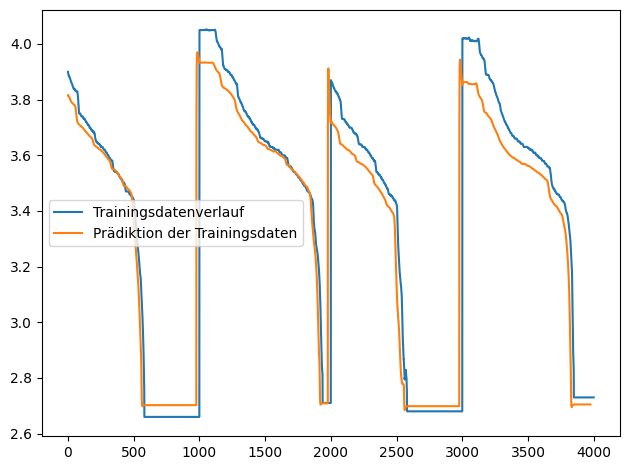

In [24]:
## CHECK IF TRAIN OR TEST
# model = load_model('Model/LGT92_LSTM_model_labled_KF_2k_newm_THESIS.h5')

### Mit Neuronalem Netz (Achtung: die y-Vorhersagen müssen reskaliert werden (wegen Standardisierung))
y_pred = model.predict(X_train)
y_pred_inv = scaler_y.inverse_transform(y_pred)

print(y_pred_inv)

plt.plot(np.linspace(1, len(y_train_raw), len(y_train_raw)), y_train_raw,
         label='Trainingsdatenverlauf')
plt.plot(np.linspace(1, len(y_pred_inv), len(y_pred_inv)), y_pred_inv,
         label='Prädiktion der Trainingsdaten')
plt.legend()
plt.tight_layout()
plt.savefig(f'../../data/png/test_predict_traindata', pad_inches=2)
plt.show()

In [25]:
print(y_pred)

[[ 0.9050114 ]
 [ 0.90922767]
 [ 0.90693915]
 ...
 [-1.4552004 ]
 [-1.4552004 ]
 [-1.4552004 ]]


4/4 [==============================] - 0s 54ms/step


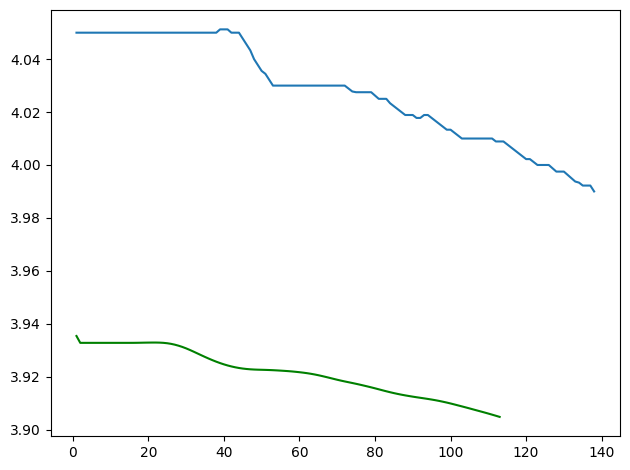

In [26]:
y_pred_test = model.predict(X_23_test)
y_pred_test_inv = scaler_y.inverse_transform(y_pred_test)
plt.plot(np.linspace(1, len(y_pred_test_inv), len(y_pred_test_inv)), y_pred_test_inv, color='green')
plt.plot(np.linspace(1, len(y_test_23_raw), len(y_test_23_raw)), y_test_23_raw)
plt.tight_layout()
# save = plt.savefig(f'../data/png/test_predict_testdata', pad_inches=2)
plt.show()

In [27]:
print(len(X_23_test))

113


In [ ]:
# Generiere Vorhersagen
# Generiere Vorhersagen
where = len(X_23_test) - 1
future_steps = 24 * 7 * 4
x_test = X_23_test[where]
current_input = x_test
print(f'Erster input: {current_input}')
y_test_future = np.zeros((future_steps,))
for i in range(future_steps):
    current_input = np.reshape(current_input, (1, window, indicators))
    y_test_future[i] = model.predict(current_input)
    print(f'Aktuelle Vorhersage{y_test_future[i]}')
    current_input = np.insert(current_input, window,
                              (y_test_future[i], x_test[0][1], x_test[0][2], x_test[0][3], x_test[0][4]), axis=1)
    print(current_input)
    current_input = np.delete(current_input, 0, axis=1)
    print(f'Input runde {i}: {current_input}')

In [ ]:
to_descale = np.reshape(y_test_future, (-1, 1))
plt.plot(np.linspace(1, len(y_train_raw[:581]), len(y_train_raw[:581])), y_train_raw[:581],
         label='Verlauf Trainingsdaten Kurve 1')
plt.plot(np.linspace(1, len(y_train_raw[1000:2000]), len(y_train_raw[1000:2000])), y_train_raw[1000:2000],
         label='Verlauf Trainingsdaten Kurve 2')
plt.plot(np.linspace(1, len(y_test_23_raw), len(y_test_23_raw)), y_test_23_raw, label='Original Testdaten')
plt.plot(np.arange(1, len(y_pred_test_inv) + 1), y_pred_test_inv, label='Predict Testdaten', color='red')
plt.plot(np.arange(where, where + len(to_descale)),
         scaler_y.inverse_transform(to_descale), label='Predict Future', color='green')
plt.legend()
plt.tight_layout()
# save = plt.savefig(f'../data/png/test_predict_future_Sensor33', pad_inches=2)
plt.show()

In [ ]:
# Generiere Vorhersagen
# Generiere Vorhersagen
where = len(X_33_test) - 1
future_steps = 24 * 7 * 4
x_test = X_33_test[where]
current_input = x_test
print(f'Erster input: {current_input}')
y_test_future = np.zeros((future_steps,))
for i in range(future_steps):
    current_input = np.reshape(current_input, (1, window, indicators))
    y_test_future[i] = model.predict(current_input)
    print(f'Aktuelle Vorhersage{y_test_future[i]}')
    current_input = np.insert(current_input, window,
                              (y_test_future[i], x_test[0][1], x_test[0][2], x_test[0][3], x_test[0][4]), axis=1)
    print(current_input)
    current_input = np.delete(current_input, 0, axis=1)
    print(f'Input runde {i}: {current_input}')

In [ ]:
y_pred_test = model.predict(X_33_test)
y_pred_test_inv = scaler_y.inverse_transform(y_pred_test)

In [ ]:
to_descale = np.reshape(y_test_future, (-1, 1))
plt.plot(np.linspace(1, len(y_test_33_raw), len(y_test_33_raw)), y_test_33_raw, label='Original Testdaten')
plt.plot(np.arange(1, len(y_pred_test_inv) + 1), y_pred_test_inv, label='Predict Testdaten', color='red')
plt.plot(np.linspace(1, len(y_train_raw[2000:2600]), len(y_train_raw[2000:2600])), y_train_raw[2000:2600],
         label='Verlauf Trainingsdaten Kurve 1')
plt.plot(np.linspace(1, len(y_train_raw[3000:]), len(y_train_raw[3000:])), y_train_raw[3000:],
         label='Verlauf Trainingsdaten Kurve 2')
plt.plot(np.arange(where, where + len(to_descale)),
         scaler_y.inverse_transform(to_descale), label='Predict Future', color='green')
plt.legend()
plt.tight_layout()
# save = plt.savefig(f'../data/png/test_predict_future_Sensor23', pad_inches=2)
plt.show()

In [ ]:
# Auswerten des Modells auf einem Testdatensatz
mae = model.evaluate(X_23_test, y_23_test)
#mae = model.evaluate(X_test, y_test, metrics=[mean_absolute_error])
#mape = model.evaluate(X_test, y_test, metrics=[mean_absolute_percentage_error])

# Ausgabe der Metriken
#print('MSE: ', mse)
print('MAE: ', mae)
#print('MAPE: ', mape)